In [1]:
import ensaio
import pandas as pd

fname = ensaio.fetch_britain_magnetic(version=1)
data = pd.read_csv(fname)
data

,line_and_segment,year,longitude,latitude,height_m,total_field_anomaly_nt
0,FL1-1,1955,-1.74162,53.48164,792,62
1,FL1-1,1955,-1.70122,53.48352,663,56
2,FL1-1,1955,-1.08051,53.47677,315,30
3,FL1-1,1955,-1.07471,53.47672,315,31
4,FL1-1,1955,-1.01763,53.47586,321,44
...,...,...,...,...,...,...
541503,FL-3(TL10-24)-1,1965,-4.68843,58.26786,1031,64
541504,FL-3(TL10-24)-1,1965,-4.68650,58.26786,1045,74
541505,FL-3(TL10-24)-1,1965,-4.68535,58.26790,1035,94
541506,FL-3(TL10-24)-1,1965,-4.68419,58.26787,1024,114


In [2]:
import verde as vd

region = (-5.5, -4.7, 57.8, 58.5)
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
data

,line_and_segment,year,longitude,latitude,height_m,total_field_anomaly_nt
383858,FL-47-2,1964,-5.38345,57.95592,305,112
383859,FL-47-2,1964,-5.38180,57.95614,305,120
383860,FL-47-2,1964,-5.38011,57.95633,305,150
383861,FL-47-2,1964,-5.37851,57.95658,305,170
383862,FL-47-2,1964,-5.37650,57.95693,305,220
...,...,...,...,...,...,...
538970,FL-16(TL24-36)-6,1965,-4.70304,58.49978,319,162
541490,FL-11-5,1965,-4.88674,58.40691,1056,245
541491,FL-11-5,1965,-4.88377,58.40689,1069,250
541492,FL-11-5,1965,-4.88202,58.40724,1055,245


In [3]:
import pyproj

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_m)
xy_region=vd.get_region(coordinates)

In [4]:
 import pygmt

 # Needed so that displaying works on jupyter-sphinx and sphinx-gallery at
 # the same time. Using PYGMT_USE_EXTERNAL_DISPLAY="false" in the Makefile
 # for sphinx-gallery to work means that fig.show won't display anything here
 # either.
 pygmt.set_display(method="notebook")

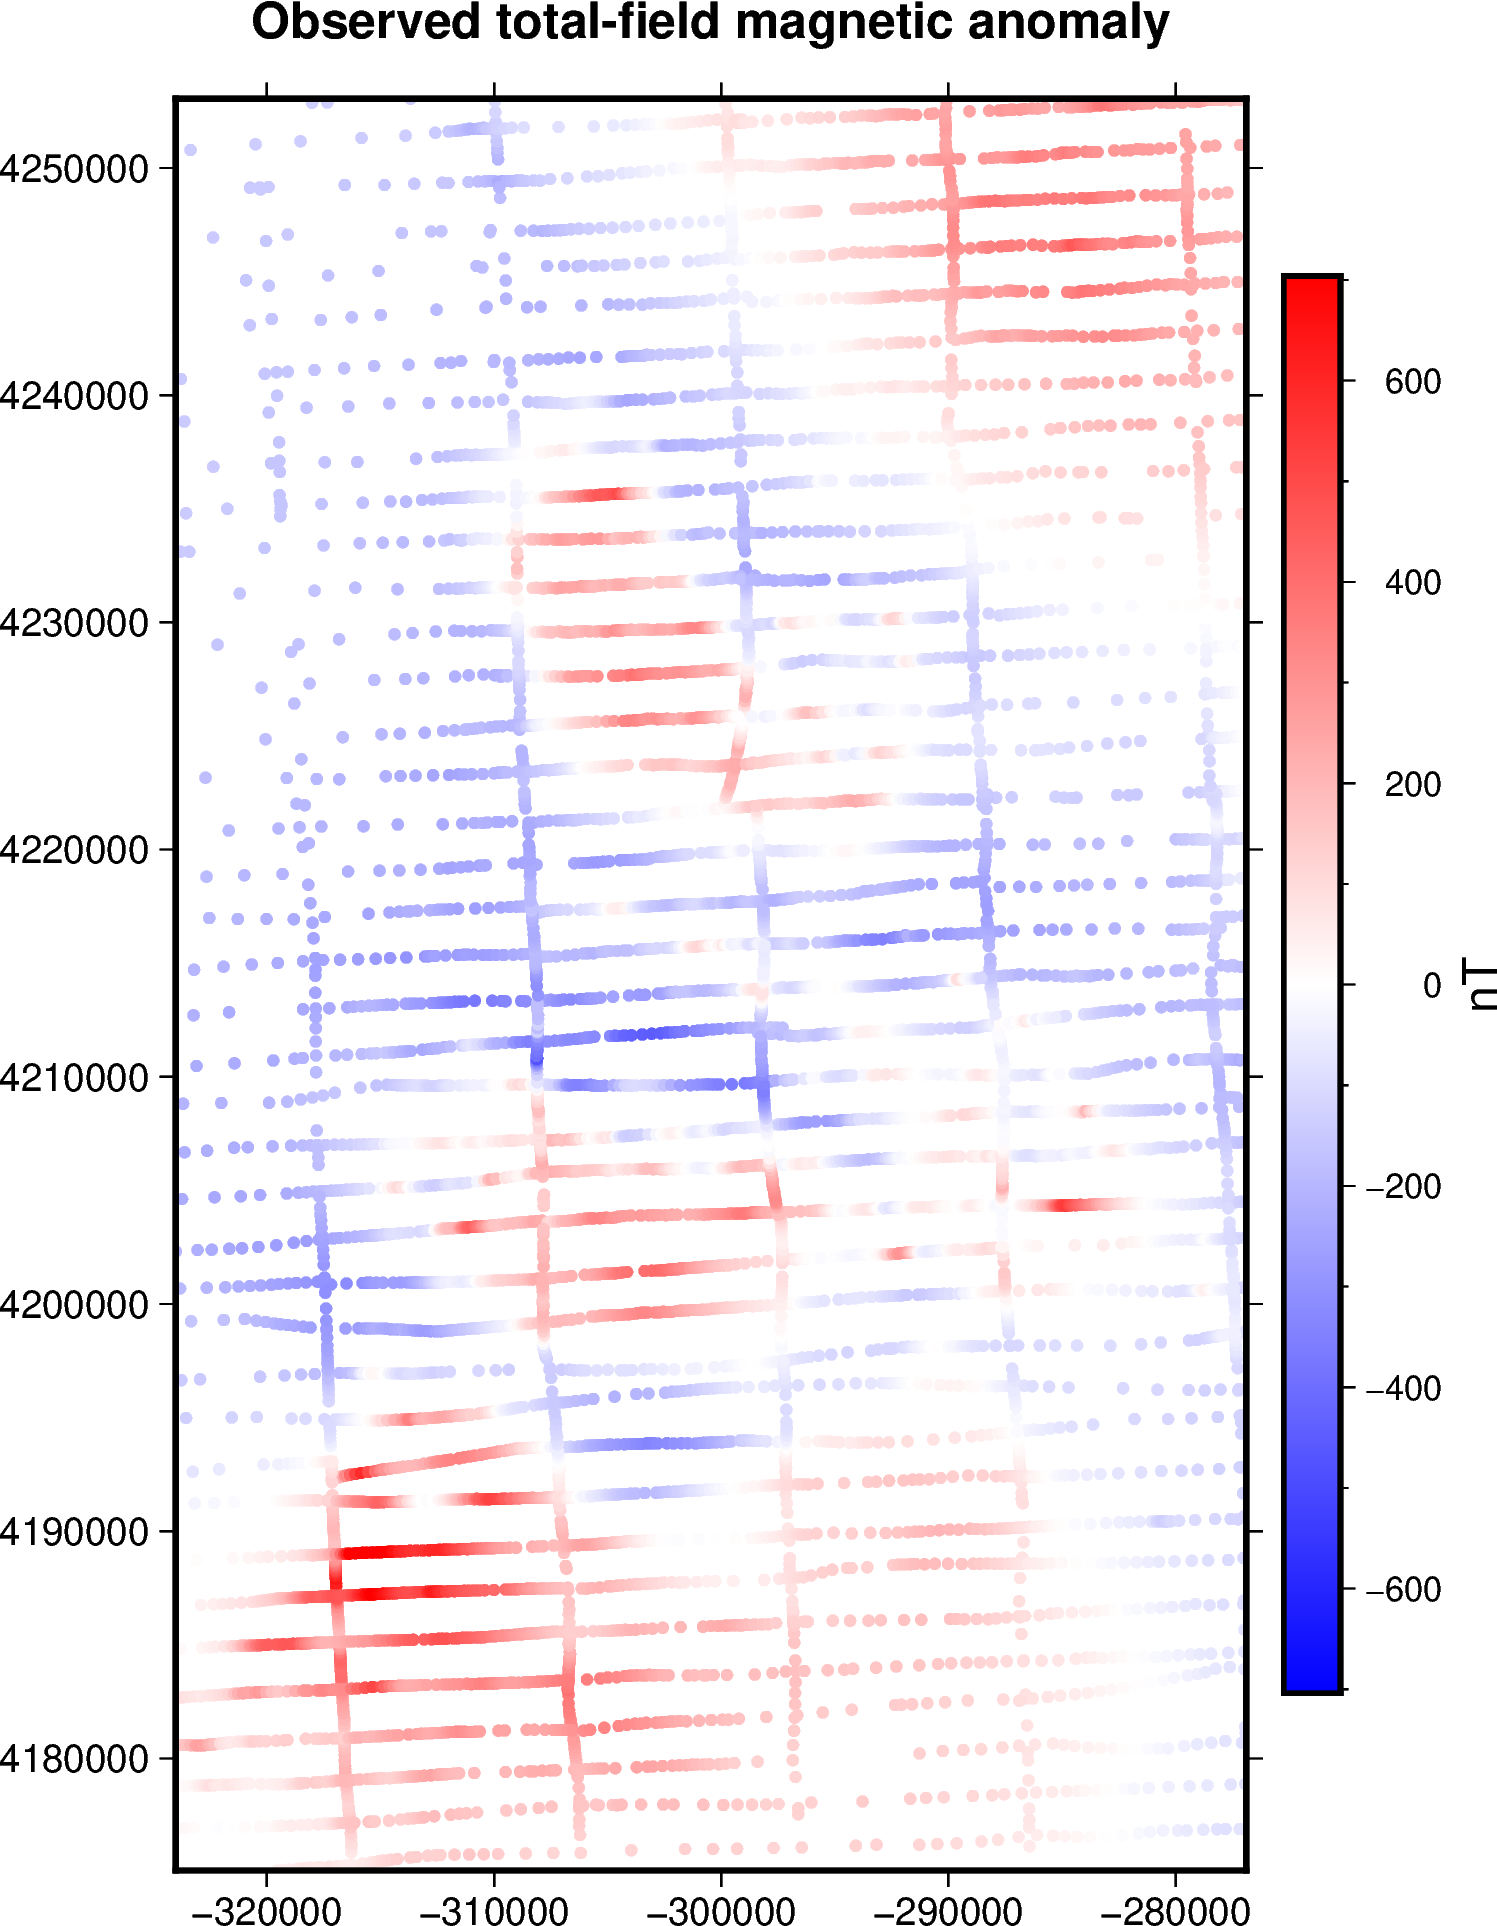

In [5]:
import pygmt

maxabs = vd.maxabs(data.total_field_anomaly_nt)*.8

# Set figure properties
w, e, s, n = xy_region
fig_height = 15
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

# Plot original magnetic anomaly and the gridded and upward-continued version
fig = pygmt.Figure()

title = "Observed total-field magnetic anomaly"

pygmt.makecpt(
    cmap="polar+h0",
    series=(-maxabs, maxabs),
    background=True,
)

with pygmt.config(FONT_TITLE="12p"):
    fig.plot(
        projection=fig_proj,
        region=xy_region,
        frame=[f"WSne+t{title}", "xa10000", "ya10000"],
        x=easting,
        y=northing,
        fill=data.total_field_anomaly_nt,
        style="c0.1c",
        cmap=True,
    )
fig.colorbar(cmap=True, position="JMR", frame=["a200f100", "x+lnT"])
fig.show()

In [6]:
import harmonica as hm

eqs = hm.EquivalentSources(depth=1000, damping=1, block_size=500)

In [7]:
eqs.fit(coordinates, data.total_field_anomaly_nt)

EquivalentSources(block_size=500, damping=1, depth=1000)

In [8]:
eqs.points_[0].size

3368

In [9]:
grid_coords = vd.grid_coordinates(
    region=vd.get_region(coordinates),
    spacing=500,
    extra_coords=1500,
)
grid = eqs.grid(grid_coords, data_names=["magnetic_anomaly"])
grid

<xarray.Dataset> Size: 241kB
Dimensions:           (northing: 157, easting: 95)
Coordinates:
  * easting           (easting) float64 760B -3.24e+05 -3.235e+05 ... -2.769e+05
  * northing          (northing) float64 1kB 4.175e+06 4.176e+06 ... 4.253e+06
    upward            (northing, easting) float64 119kB 1.5e+03 ... 1.5e+03
Data variables:
    magnetic_anomaly  (northing, easting) float64 119kB 30.31 30.5 ... 151.0
Attributes:
    metadata:  Generated by EquivalentSources(block_size=500, damping=1, dept...

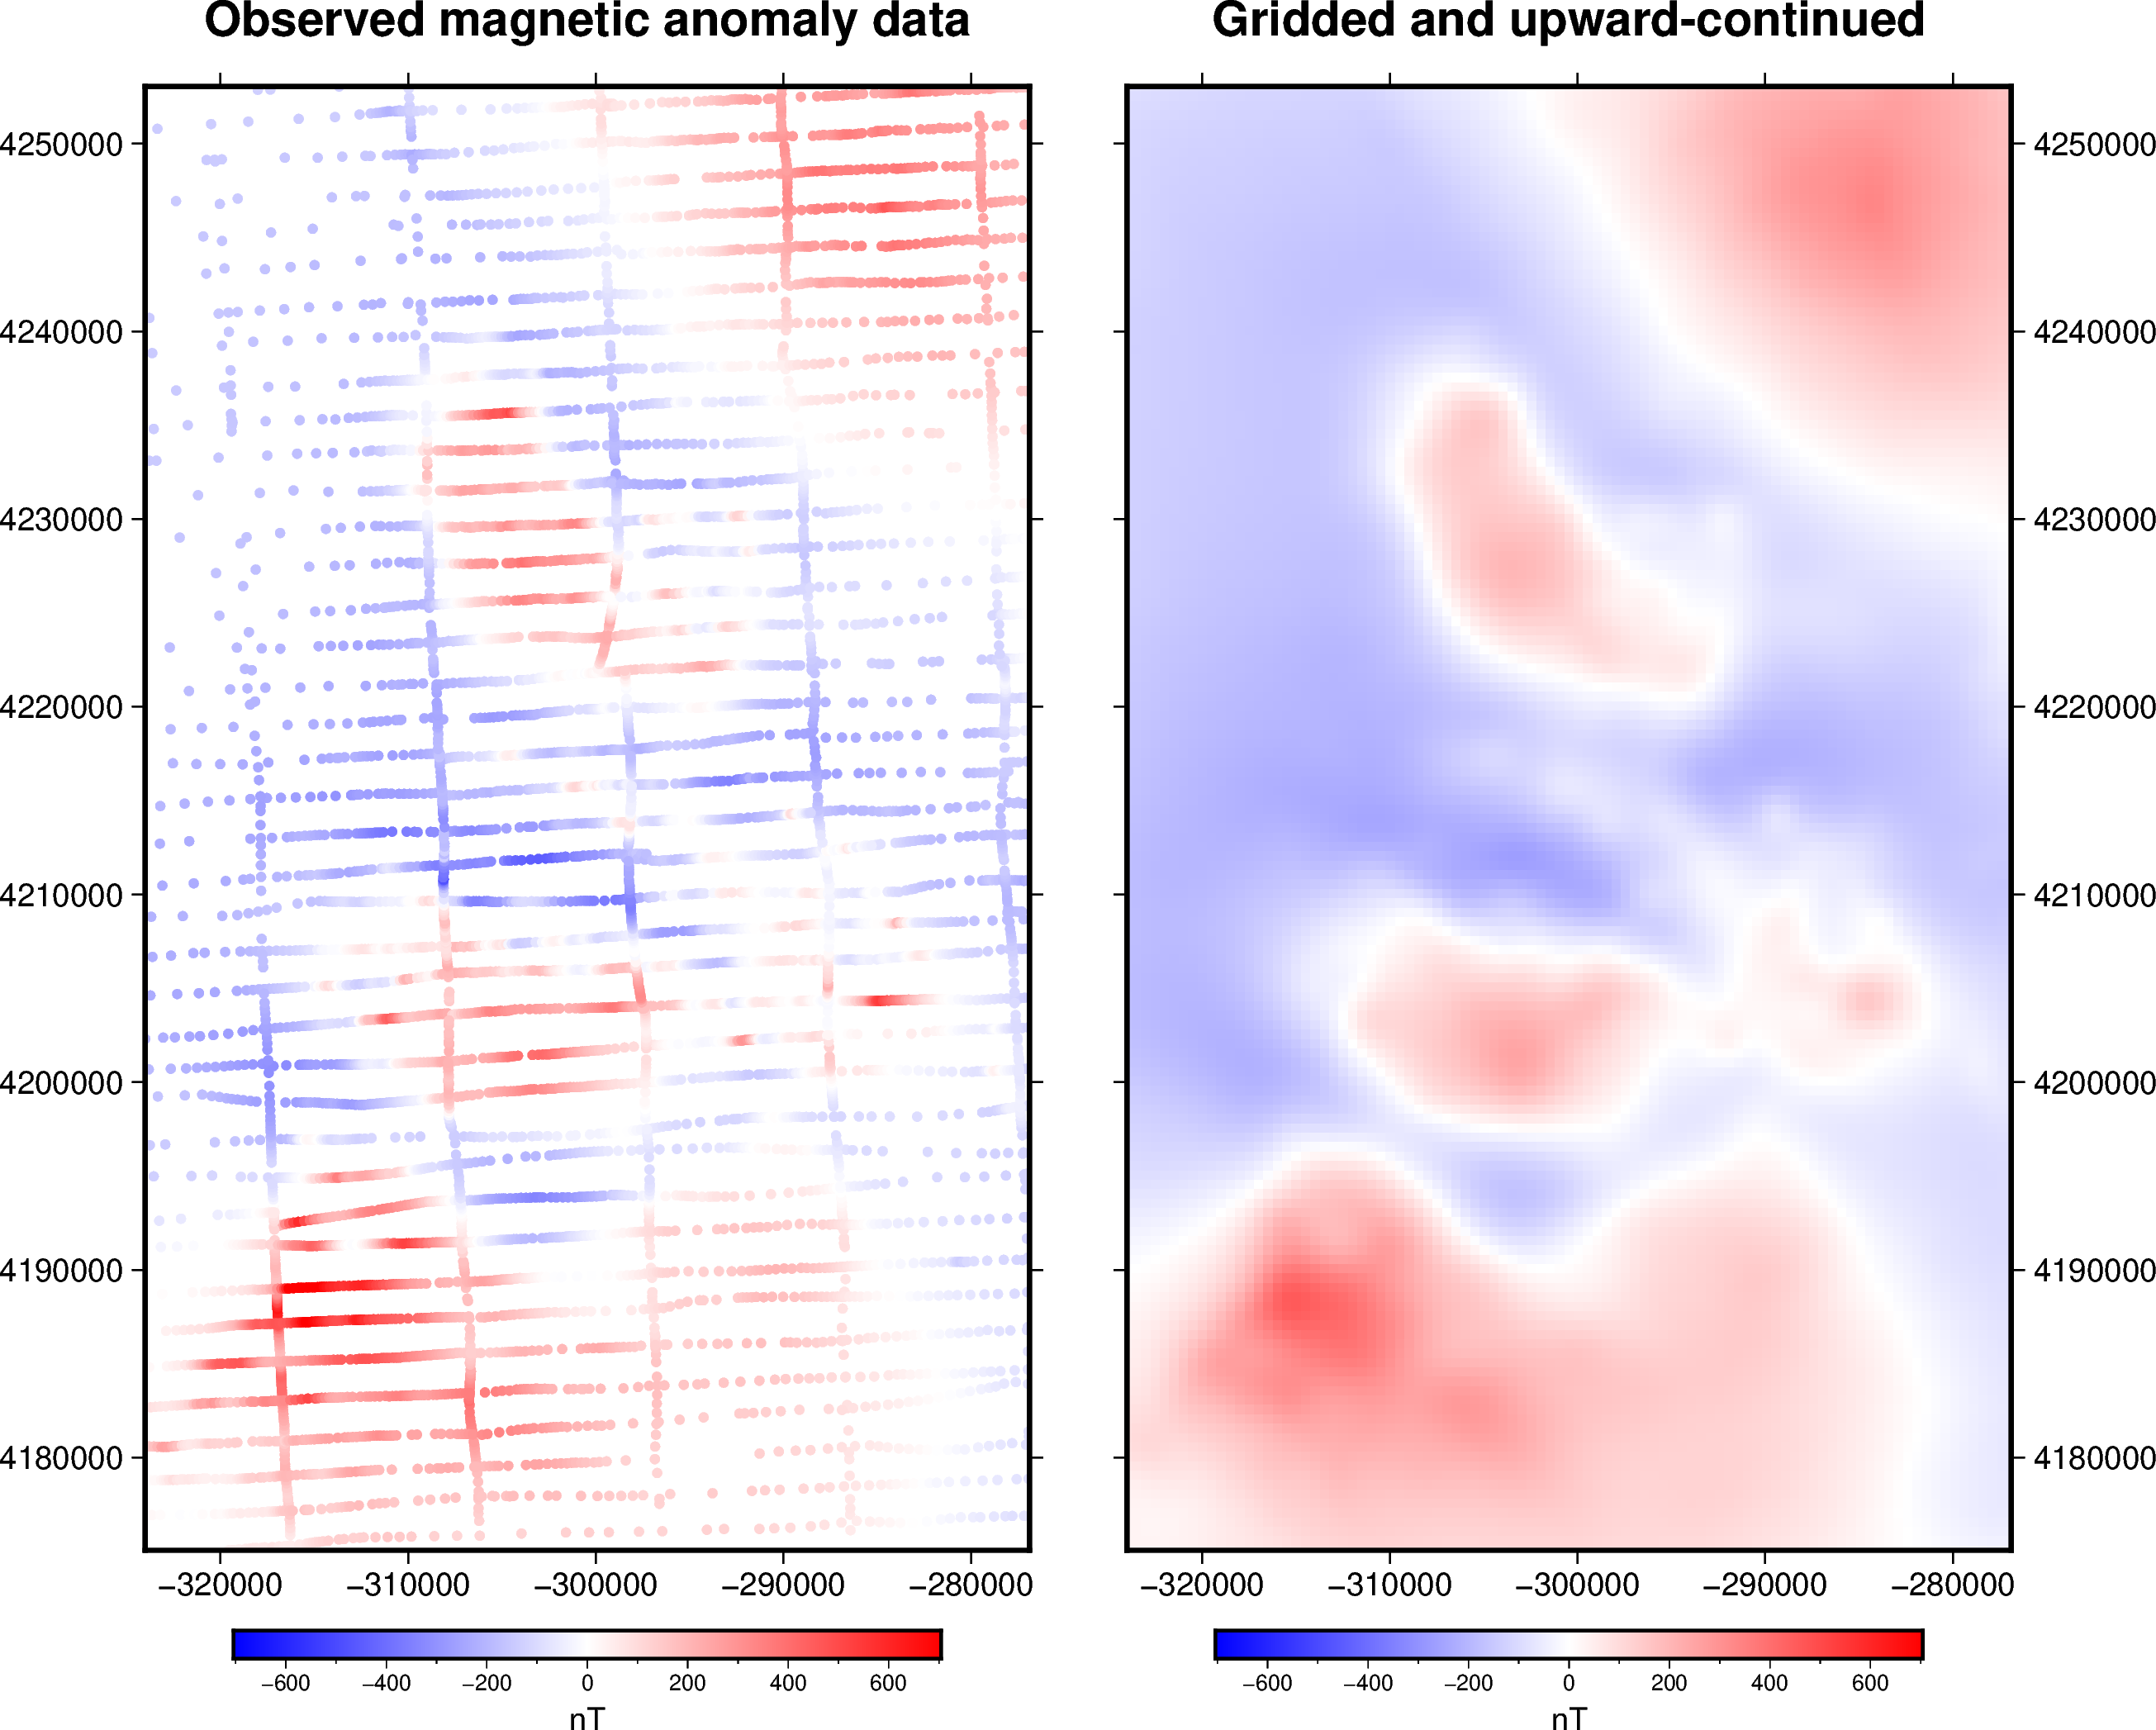

In [10]:
fig = pygmt.Figure()

title = "Observed magnetic anomaly data"
pygmt.makecpt(
    cmap="polar+h0",
    series=(-maxabs, maxabs),
    background=True)

with pygmt.config(FONT_TITLE="14p"):
    fig.plot(
        projection=fig_proj,
        region=xy_region,
        frame=[f"WSne+t{title}", "xa10000", "ya10000"],
        x=easting,
        y=northing,
        fill=data.total_field_anomaly_nt,
        style="c0.1c",
        cmap=True,
    )
fig.colorbar(cmap=True, frame=["a200f100", "x+lnT"])

fig.shift_origin(xshift=fig_width + 1)

title = "Gridded and upward-continued"

with pygmt.config(FONT_TITLE="14p"):
    fig.grdimage(
        frame=[f"ESnw+t{title}", "xa10000", "ya10000"],
        grid=grid.magnetic_anomaly,
        cmap=True,
    )
fig.colorbar(cmap=True, frame=["a200f100", "x+lnT"])

fig.show()